# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [3]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir


plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/'

os.system("mkdir -p "+ plotDir)

0

# ALL BKG TAG EFF

In [5]:
tags = []
tags = [
    
#         'Data 2016B-F SingleMuon',
#         'Data 2016G-H SingleMuon',
#         'Data 2017 SingleMuon',
#         'Data 2018 SingleMuon',
#         'MC 2016 WJets_Mu',
#         'MC 2017 WJets_Mu',
#         'MC 2018 WJets_Mu',

        'Data 2016B-F SinglePhoton',
        'Data 2016G-H SinglePhoton',
        'Data 2017 SinglePhoton',
        'Data 2018 SinglePhoton',
        'MC 2016 QCD_Pho',
        'MC 2017 QCD_Pho',
        'MC 2018 QCD_Pho',


 
        ]

# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

# fnames['Data 2016'] = 'V1p17/v5/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_GoodLumi.root'
# fnames['Data 2017'] = 'V1p17/v5/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root'
# fnames['Data 2018'] = 'V1p17/v5/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018_GoodLumi.root'

fnames['Data 2016B-F SingleMuon'] = 'V1p17/v13/Data2016_AOD/SingleMuon/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016B-F-07Aug17.root'
fnames['Data 2016G-H SingleMuon'] = 'V1p17/v13/Data2016_AOD/SingleMuon/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016G-H-07Aug17.root'
fnames['Data 2017 SingleMuon'] = 'V1p17/v13/Data2017_AOD/SingleMuon/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-17Nov2017.root'
fnames['Data 2018 SingleMuon'] = 'V1p17/v13/Data2018_AOD/SingleMuon/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root'

fnames['MC 2016 WJets_Mu'] = 'V1p17/v13/MC_Summer16/WJetsToLNu_Mu/normalized/WJetsToLNu_HT-70ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['MC 2017 WJets_Mu'] =  'V1p17/v13/MC_Fall17/WJetsToLNu_Mu/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['MC 2018 WJets_Mu'] =  'V1p17/v13/MC_Fall18/WJetsToLNu_Mu/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

fnames['Data 2016B-F SinglePhoton'] = 'V1p17/v13/Data2016_AOD/SinglePhoton/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016B-F-07Aug17.root'
fnames['Data 2016G-H SinglePhoton'] = 'V1p17/v13/Data2016_AOD/SinglePhoton/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016G-H-07Aug17.root'
fnames['Data 2017 SinglePhoton'] = 'V1p17/v13/Data2017_AOD/SinglePhoton/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-17Nov2017.root'
fnames['Data 2018 SinglePhoton'] = 'V1p17/v13/Data2018_AOD/SinglePhoton/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root'

fnames['MC 2016 QCD_Pho'] = 'V1p17/v13/MC_Summer16/QCD_Pho/normalized/QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['MC 2017 QCD_Pho'] =  'V1p17/v13/MC_Fall17/QCD_Pho/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['MC 2018 QCD_Pho'] =  'V1p17/v13/MC_Fall18/QCD_Pho/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPPassFailTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetPt'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
    jet_amax = v['pileupWeight'].array()
    print(np.unique(jet_amax))
     

/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v13/Data2016_AOD/SinglePhoton/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016B-F-07Aug17.root
Open ready
Data 2016B-F SinglePhoton
Tree ready
<TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8> OrderedDict([('Data 2016B-F SinglePhoton', <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>)])
[[109.48605] [67.26787] [121.49781] ... [193.25787] [209.07118] [30.798508]]
[ 1.  1. 80.  1.  1. 60. 15.  1.  1. 15.]
[1.00e+00 4.00e+00 8.00e+00 9.00e+00 1.00e+01 1.10e+01 1.20e+01 1.30e+01
 1.40e+01 1.50e+01 1.70e+01 1.80e+01 2.00e+01 2.10e+01 2.20e+01 2.30e+01
 3.00e+01 3.40e+01 3.50e+01 4.00e+01 4.30e+01 4.50e+01 4.60e+01 5.00e+01
 6.00e+01 7.00e+01 7.50e+01 8.00e+01 9.00e+01 1.00e+02 1.15e+02 1.20e+02
 1.30e+02 1.40e+02 1.50e+02 1.60e+02 1.80e+02 2.00e+02 2.30e+02 2.60e+02
 2.80e+02 3.00e+02 3.20e+02 3.50e+02 3.60e+02 4.00e+02 4.60e+02 5.20e+02
 7.00e+02 7.20e+02 1.00e+03 1.10e+03 1.40e+03 1.50e+03 1.60e

# Tag Eff Measurement Region

In [6]:


trg_jet_w = {} 
trg_jet_pu = {} 
trg_jet_pt = {}
trg_jet_pass = {}


for k,v in tree.items():
    print(k,v)

    # branches

    #jet var
    pt = v['jetPt'].array()
    pf = v['jetPass'].array()
 
    weight = v['weight'].array()
    if 'MC' in k:
        pu = v['pileupWeight'].array()
    
    print(weight.shape)
    
    #selection
    
    trg_jet_pt[k] = pt
    trg_jet_pass[k] = pf

    trg_jet_w[k] = weight 
    if 'MC' in k:
        trg_jet_pu[k] = pu 

    #print out check

    print(len(trg_jet_pt[k]))   
    print(len(trg_jet_pass[k]))
    
    print(len(trg_jet_w[k]))
    if 'MC' in k:
        print(len(trg_jet_pu[k]))
    

Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
(92351,)
92351
92351
92351
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
(59804,)
59804
59804
59804
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
(74147,)
74147
74147
74147
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
(918,)
918
918
918
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
(12749,)
12749
12749
12749
12749
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
(5602,)
5602
5602
5602
5602
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
(4781,)
4781
4781
4781
4781


In [7]:
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/'+'Mu/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/'+'Mu_pileupW/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/'+'Pho_pileupW/'

 

print(plotDir)
os.system("mkdir -p "+ plotDir)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/


0

# Tags

In [8]:

nTags = {}
nJets = {}

tag_jet_pt = {}

pt_cut=30

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_pass[k] , trg_jet_pt[k]>pt_cut)
 
#     untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 

    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
[[109.48605] [67.26787] [121.49781] ... [193.25787] [209.07118] [30.798508]]
[[] [] [] ... [] [] []]
[1]
[0 1]
[0 1]
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
[[252.61244] [150.17085] [30.554342] ... [56.941044] [42.404556] [546.065]]
[[] [] [] ... [] [] []]
[1]
[0 1]
[0 1]
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
[[38.5159] [47.568233] [52.68359] ... [44.152966] [85.8089] [49.258617]]
[[] [] [] ... [] [] []]
[1]
[0 1]
[0 1]
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
[[471.61856] [286.87982] [315.3397] ... [199.9489] [113.72618] [131.0707]]
[[] [] [] ... [] [] []]
[1]
[0]
[0]
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
[[529.92267] [482.84702] [460.8173] ... [110.44763] [581.7674] [628.9558]]
[[] [] [] ... [] [] []]
[1]
[0 1]
[0 1]
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
[[42

# Tag Eff

In [9]:
from itertools import chain 

wall = {}
wnum = {}

#var
pt_denall = {}
pt_numall = {}

#h1s
pt_den_all = {}
pt_num_all = {}

#pEffs of h1
pt_pEff = {}


for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    if 'Data' in k:
        wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    if 'MC' in k:
        wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k]*trg_jet_pu[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    
    if 'Data' in k:
        wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    if 'MC' in k:
        wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k]*trg_jet_pu[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
    
    print(len(pt_numall[k]))
    print(len(wnum[k]))
    
    #pt histogram
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])


    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
    
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    print(pt_den_all[k].GetNbinsX())

    
 
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])


Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
92351
92351
114
114
100
19
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
59804
59804
59
59
100
19
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
74147
74147
86
86
100
19
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
918
918
0
0
100
19
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
12749
12749
9
9
100
19
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
5602
5602
5
5
100
19
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
4781
4781
2
2
100
19


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old hist

In [10]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.01],
 
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.01
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only s

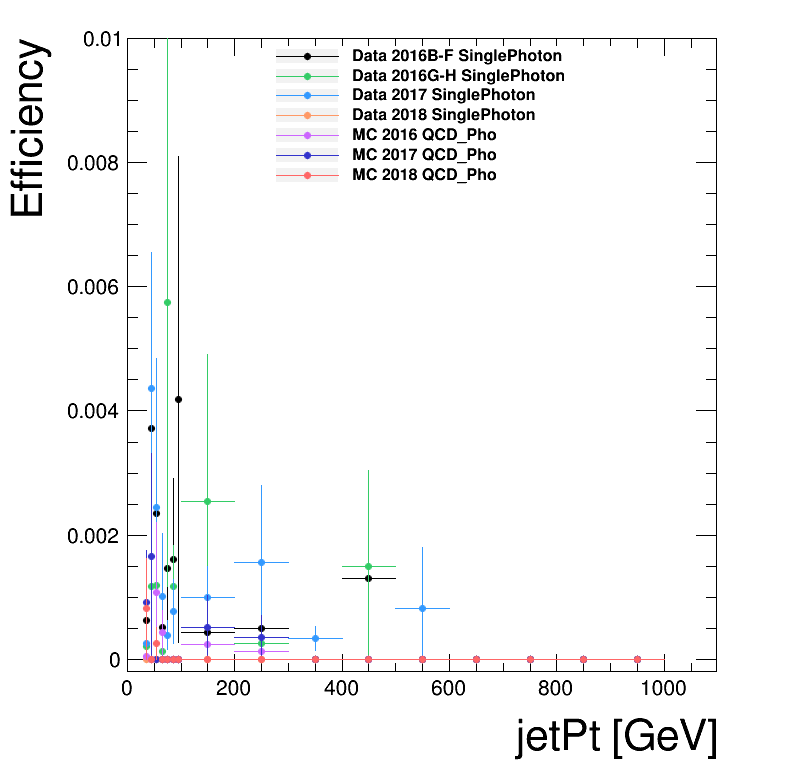

In [11]:

   

color_list = [1,845,861,806,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'

    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)
    

        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

#     c.SetLogx()
#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


var/x_axis jetPt [GeV] name pt range -0.0002 0.01
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_logX.png has been created


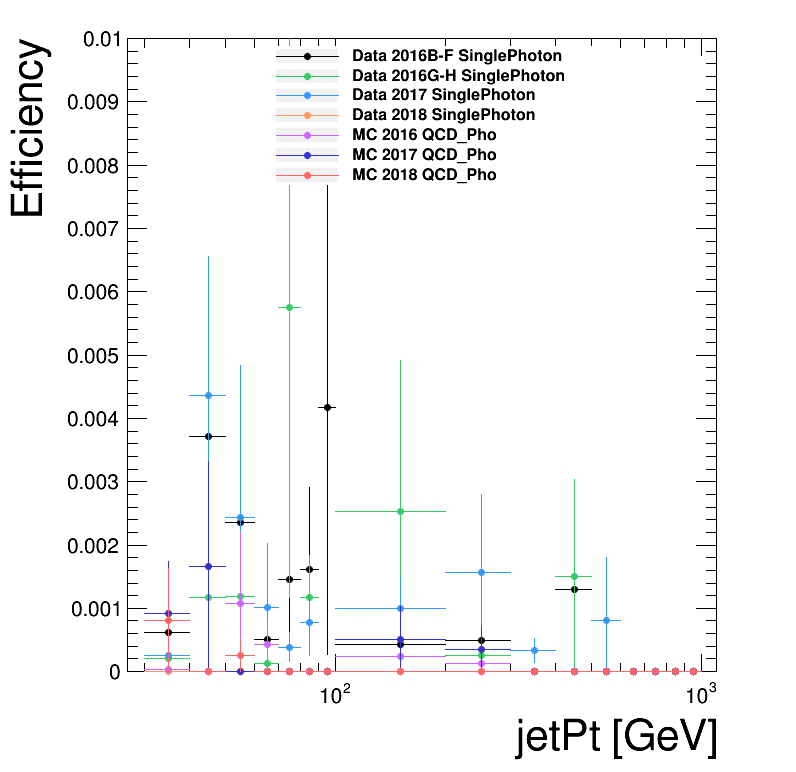

In [12]:

   

color_list = [1,845,861,806,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
#     outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin_logX.png'
#     outf = 'tag_eff_jet_'+var[2]+'_rebin_comparison.png'
#     outf = 'tag_eff_jet_'+var[2]+'_rebin_2017_2018.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    c.SetLogx()
#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


In [13]:
variables = [
    
 
        ['jetPt [GeV]', pt_denall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet.png has been created


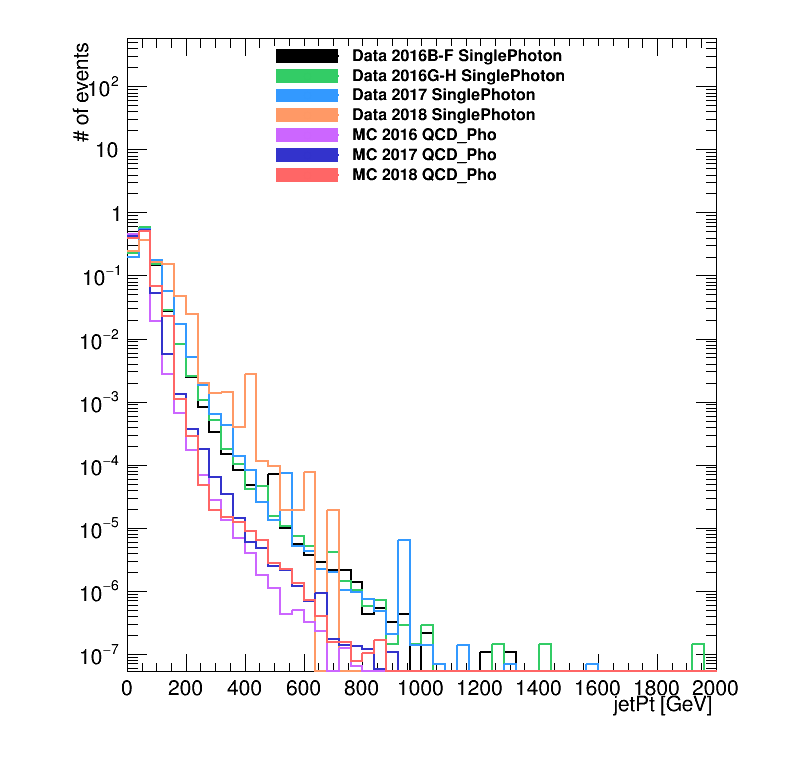

In [14]:

   

color_list = [1,845,861,806,876,597,625]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    outf = 'pt_jet.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
            ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wall[k])
           

            ptHist[k].SetLineColor(color_list[i])
            ptHist[k].SetMarkerColor(color_list[i])
            ptHist[k].SetMarkerSize(0.8)
            ptHist[k].SetMarkerStyle(20)

#             if i==0:
#                 ptHist[k].Draw("ahist")
#             else:
#                 ptHist[k].Draw("histsame")

#            ptHist[k].Sumw2()
          
            ptHist[k].GetXaxis().SetTitleSize(0.03)
            ptHist[k].GetYaxis().SetTitleSize(0.03)
            ptHist[k].GetXaxis().SetLabelSize(0.03)
            ptHist[k].GetYaxis().SetLabelSize(0.03)
            ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
            ptHist[k].DrawNormalized("Hist same")

            peHist[k] =ptHist[k].Clone()
            peHist[k].SetFillColor(color_list[i])
            #            peHist[k].Draw("e2 same")

            leg.AddEntry(peHist[k],k )


            i += 1



#             leg.AddEntry(pEff[k],k)

    leg.Draw()

#     c.SetLogx()
    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


In [15]:
variables = [
    
 
        ['jetPt [GeV]', pt_numall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_pass.png has been created


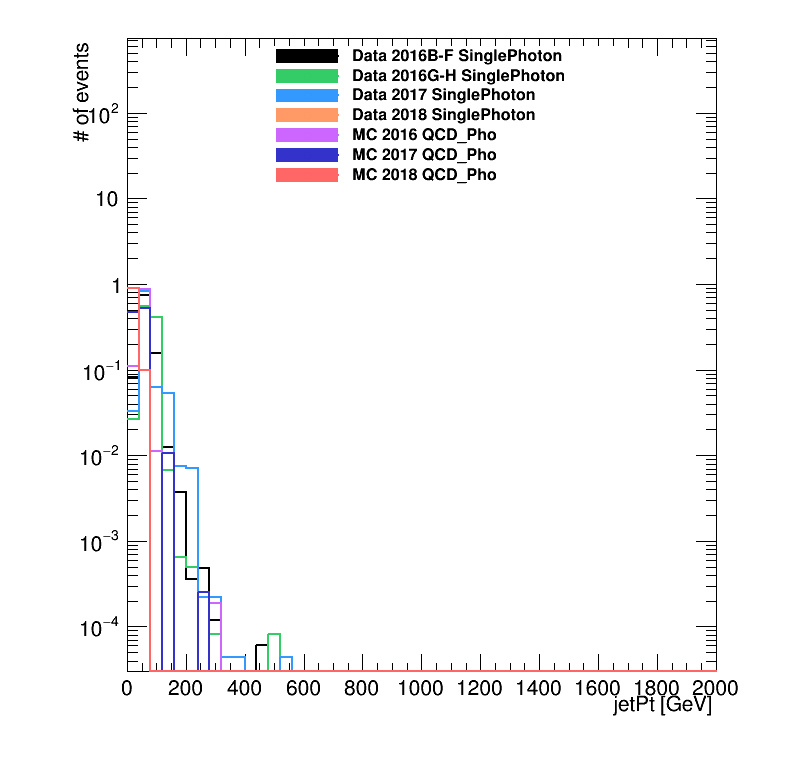

In [16]:

   

color_list = [1,845,861,806,876,597,625]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    outf = 'pt_jet_pass.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
            ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wnum[k])
           

            ptHist[k].SetLineColor(color_list[i])
            ptHist[k].SetMarkerColor(color_list[i])
            ptHist[k].SetMarkerSize(0.8)
            ptHist[k].SetMarkerStyle(20)

#             if i==0:
#                 ptHist[k].Draw("ahist")
#             else:
#                 ptHist[k].Draw("histsame")

#            ptHist[k].Sumw2()
          
            ptHist[k].GetXaxis().SetTitleSize(0.03)
            ptHist[k].GetYaxis().SetTitleSize(0.03)
            ptHist[k].GetXaxis().SetLabelSize(0.03)
            ptHist[k].GetYaxis().SetLabelSize(0.03)
            ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
            ptHist[k].DrawNormalized("Hist same")

            peHist[k] =ptHist[k].Clone()
            peHist[k].SetFillColor(color_list[i])
            #            peHist[k].Draw("e2 same")

            leg.AddEntry(peHist[k],k )


            i += 1



#             leg.AddEntry(pEff[k],k)

    leg.Draw()

#     c.SetLogx()
    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


# Years

In [17]:
years=['2016','2017','2018']


In [22]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/'+'Mu/'

print(plotDir)
os.system("mkdir -p "+ plotDir)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Mu/


0

# original years

In [18]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.01],

        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.01
2016
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
2017
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'Su

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_logX_2016.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_logX_2017.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_logX_2018.png has been created


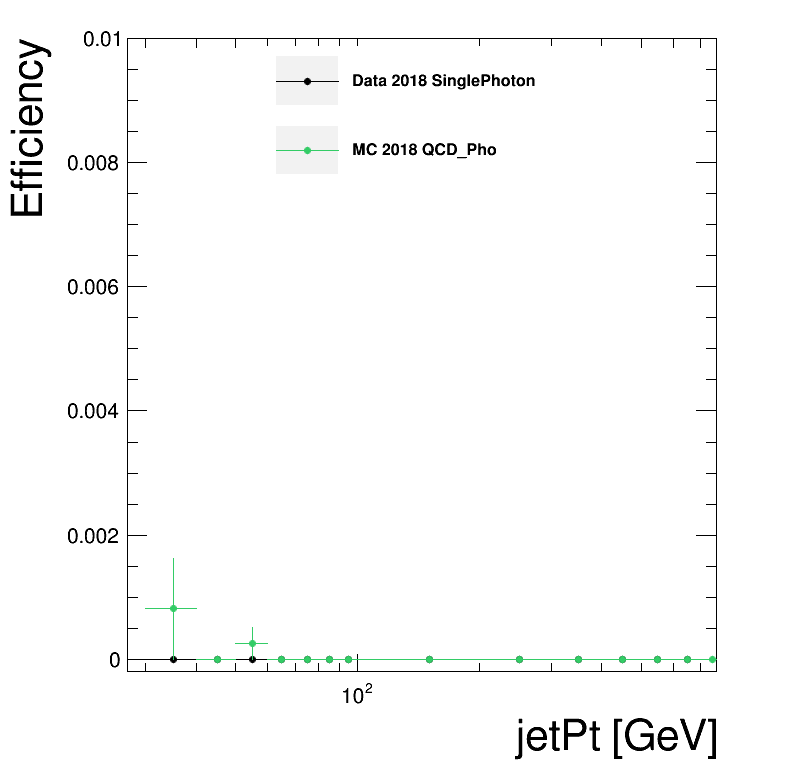

In [19]:

   

color_list = [1,845,861,806,876,597,625, 221, 225]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
  

    for yr in years:
        print(yr)
        outf = 'tag_eff_jet_'+var[2]+'_rebin_logX_'+str(yr)+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if yr in k:
                if 'bb' not in k:
        #         if 'QCD' in k:
                    pEff[k] = var[1][k]
        #             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
        #             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
                    pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

                    pEff[k].SetLineColor(color_list[i])
                    pEff[k].SetMarkerColor(color_list[i])
                    pEff[k].SetMarkerSize(0.8)
                    pEff[k].SetMarkerStyle(20)

                    if i==0:
                        pEff[k].Draw("apez")
                    else:
                        pEff[k].Draw("pezsame")

                    rt.gPad.Update()        
                    #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
                    pEff[k].GetPaintedGraph().SetMarkerStyle(8)
                    pEff[k].GetPaintedGraph().SetMarkerSize(20)        
                    pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMinimum(var[3])
                    pEff[k].GetPaintedGraph().SetMaximum(var[4])
                    pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
                    pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


                    i += 1



                    leg.AddEntry(pEff[k],k)

        leg.Draw()

        c.SetLogx()
    #     c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


var/x_axis jetPt [GeV] name pt range -0.0002 0.01
2016
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
2017
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'Su

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_linearX_2016.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_linearX_2017.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_linearX_2018.png has been created


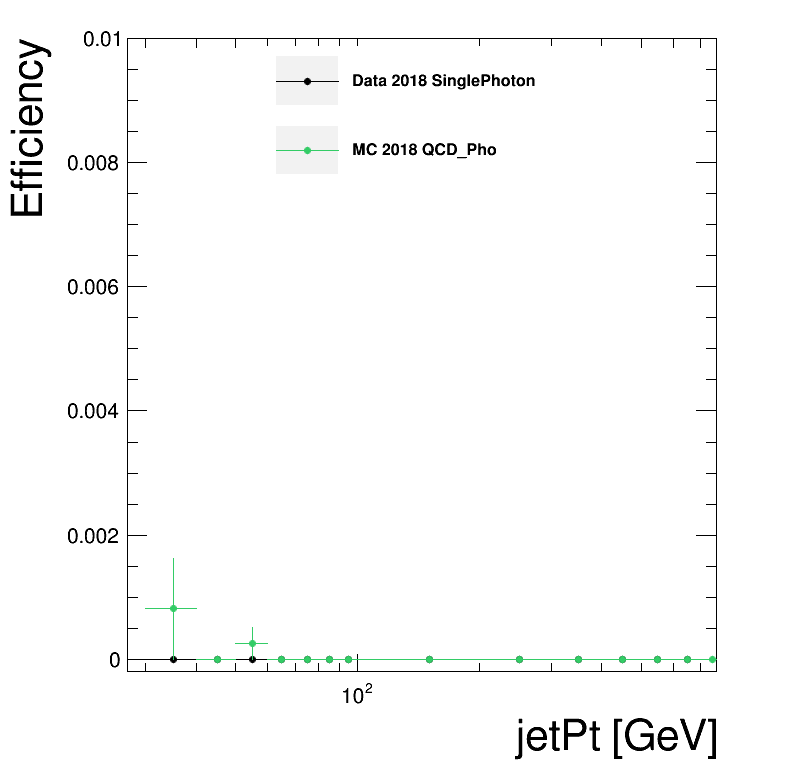

In [20]:

   

color_list = [1,845,861,806,876,597,625, 221, 225]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
  

    for yr in years:
        print(yr)
        outf = 'tag_eff_jet_'+var[2]+'_rebin_linearX_'+yr+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if yr in k:
                if 'bb' not in k:
        #         if 'QCD' in k:
                    pEff[k] = var[1][k]
        #             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
        #             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
                    pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

                    pEff[k].SetLineColor(color_list[i])
                    pEff[k].SetMarkerColor(color_list[i])
                    pEff[k].SetMarkerSize(0.8)
                    pEff[k].SetMarkerStyle(20)

                    if i==0:
                        pEff[k].Draw("apez")
                    else:
                        pEff[k].Draw("pezsame")

                    rt.gPad.Update()        
                    #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
                    pEff[k].GetPaintedGraph().SetMarkerStyle(8)
                    pEff[k].GetPaintedGraph().SetMarkerSize(20)        
                    pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMinimum(var[3])
                    pEff[k].GetPaintedGraph().SetMaximum(var[4])
                    pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
                    pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


                    i += 1



                    leg.AddEntry(pEff[k],k)

        leg.Draw()

        c.SetLogx()
    #     c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


In [21]:
variables = [
    
 
        ['jetPt [GeV]', pt_denall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
2016
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
2017
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPP

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_2016.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_2017.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_2018.png has been created


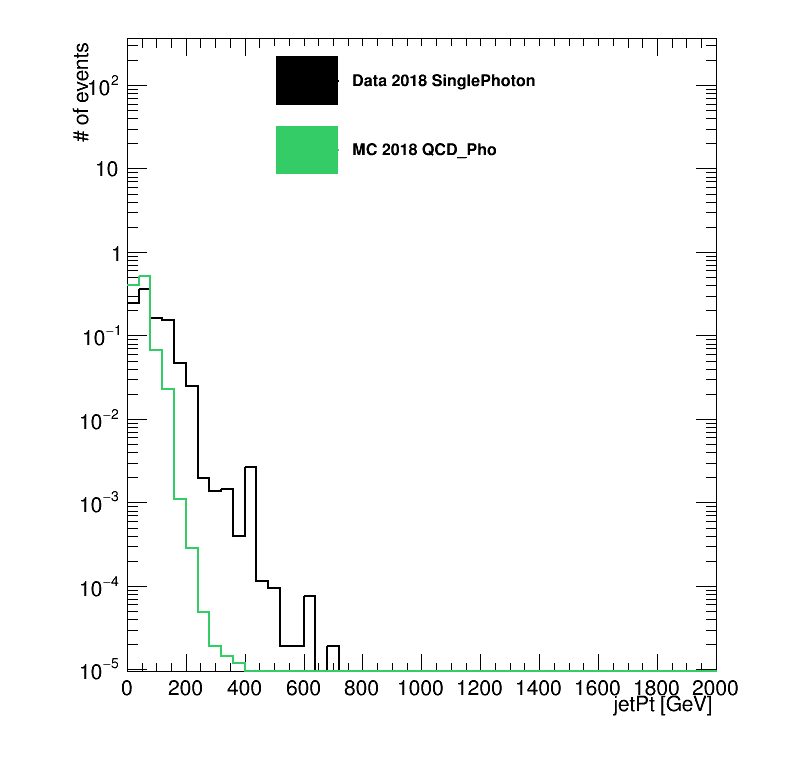

In [22]:

   

color_list = [1,845,861,806,876,597,625, 221, 225, 201, 217]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    for yr in years:
        print(yr)
        outf = 'pt_jet_'+yr+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if yr in k:


                if 'bb' not in k:
                    ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wall[k])


                    ptHist[k].SetLineColor(color_list[i])
                    ptHist[k].SetMarkerColor(color_list[i])
                    ptHist[k].SetMarkerSize(0.8)
                    ptHist[k].SetMarkerStyle(20)

        #             if i==0:
        #                 ptHist[k].Draw("ahist")
        #             else:
        #                 ptHist[k].Draw("histsame")

        #            ptHist[k].Sumw2()

                    ptHist[k].GetXaxis().SetTitleSize(0.03)
                    ptHist[k].GetYaxis().SetTitleSize(0.03)
                    ptHist[k].GetXaxis().SetLabelSize(0.03)
                    ptHist[k].GetYaxis().SetLabelSize(0.03)
                    ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
                    ptHist[k].DrawNormalized("Hist same")

                    peHist[k] =ptHist[k].Clone()
                    peHist[k].SetFillColor(color_list[i])
                    #            peHist[k].Draw("e2 same")

                    leg.AddEntry(peHist[k],k )


                    i += 1


        leg.Draw()

    #     c.SetLogx()
        c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


In [23]:
variables = [
    
 
        ['jetPt [GeV]', pt_numall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
2016
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
2017
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPP

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_pass_2016.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_pass_2017.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_pass_2018.png has been created


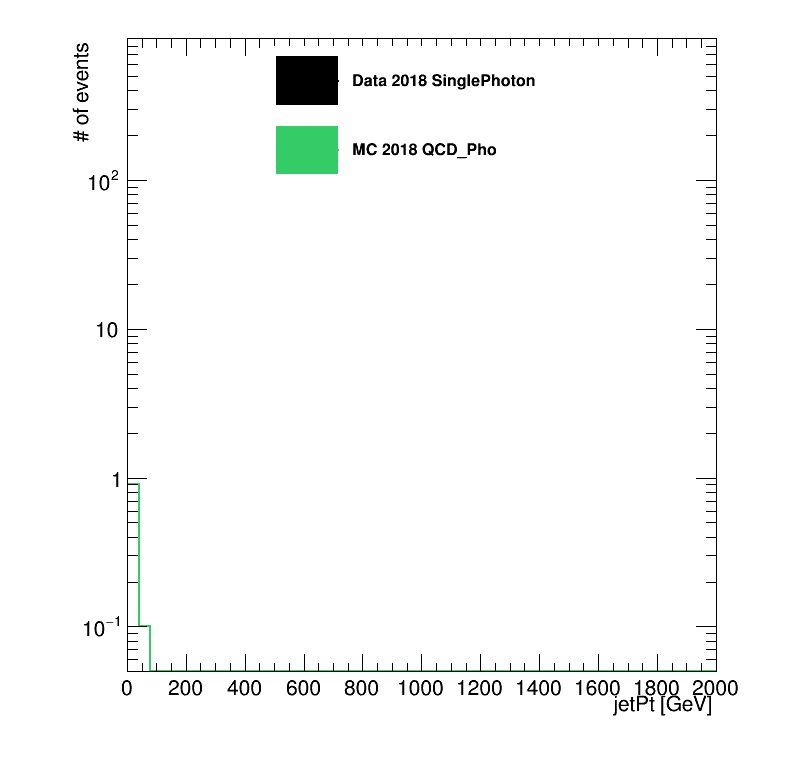

In [24]:

   

color_list = [1,845,861,806,876,597,625, 221, 225, 201, 217]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    for yr in years:
        print(yr)
        outf = 'pt_jet_pass_'+yr+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if yr in k:


                if 'bb' not in k:
                    ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wnum[k])


                    ptHist[k].SetLineColor(color_list[i])
                    ptHist[k].SetMarkerColor(color_list[i])
                    ptHist[k].SetMarkerSize(0.8)
                    ptHist[k].SetMarkerStyle(20)

        #             if i==0:
        #                 ptHist[k].Draw("ahist")
        #             else:
        #                 ptHist[k].Draw("histsame")

        #            ptHist[k].Sumw2()

                    ptHist[k].GetXaxis().SetTitleSize(0.03)
                    ptHist[k].GetYaxis().SetTitleSize(0.03)
                    ptHist[k].GetXaxis().SetLabelSize(0.03)
                    ptHist[k].GetYaxis().SetLabelSize(0.03)
                    ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
                    ptHist[k].DrawNormalized("Hist same")

                    peHist[k] =ptHist[k].Clone()
                    peHist[k].SetFillColor(color_list[i])
                    #            peHist[k].Draw("e2 same")

                    leg.AddEntry(peHist[k],k )


                    i += 1


        leg.Draw()

    #     c.SetLogx()
        c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


# Cases

In [25]:
cases=['Data', 'MC']
# cases=['Data']
# cases=['MC']

In [26]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.01],

        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.01
Data
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
MC
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'Susy

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_logX_Data.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_logX_MC.png has been created


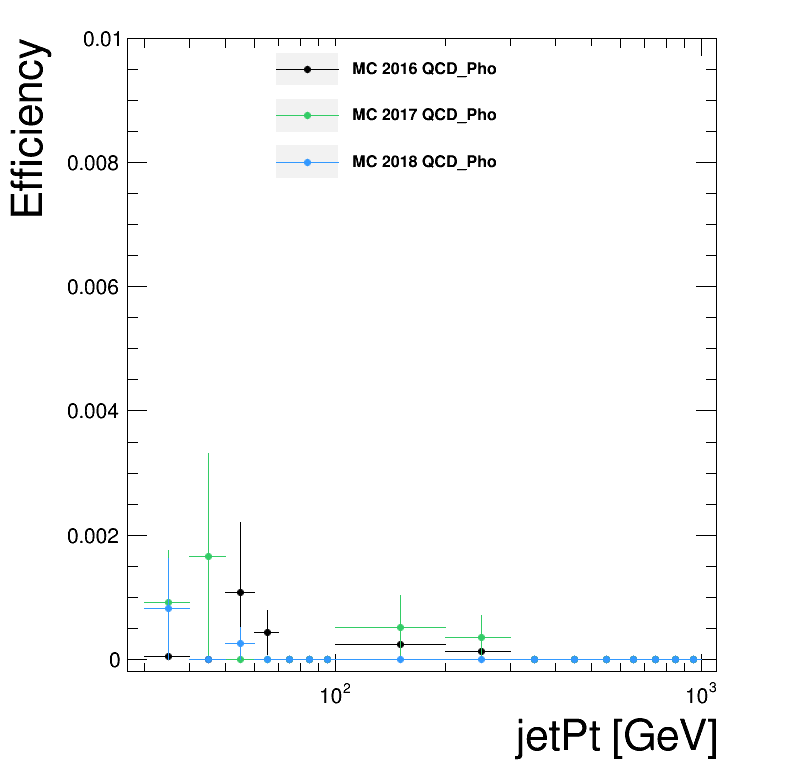

In [27]:

   

color_list = [1,845,861,806,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
  

    for case in cases:
        print(case)
        outf = 'tag_eff_jet_'+var[2]+'_rebin_logX_'+case+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if case in k:
                if 'bb' not in k:
        #         if 'QCD' in k:
                    pEff[k] = var[1][k]
        #             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
        #             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
                    pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

                    pEff[k].SetLineColor(color_list[i])
                    pEff[k].SetMarkerColor(color_list[i])
                    pEff[k].SetMarkerSize(0.8)
                    pEff[k].SetMarkerStyle(20)

                    if i==0:
                        pEff[k].Draw("apez")
                    else:
                        pEff[k].Draw("pezsame")

                    rt.gPad.Update()        
                    #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
                    pEff[k].GetPaintedGraph().SetMarkerStyle(8)
                    pEff[k].GetPaintedGraph().SetMarkerSize(20)        
                    pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMinimum(var[3])
                    pEff[k].GetPaintedGraph().SetMaximum(var[4])
                    pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
                    pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


                    i += 1



                    leg.AddEntry(pEff[k],k)

        leg.Draw()

        c.SetLogx()
    #     c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


var/x_axis jetPt [GeV] name pt range -0.0002 0.01
Data
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
MC
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'Susy

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_linearX_Data.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/tag_eff_jet_pt_rebin_linearX_MC.png has been created


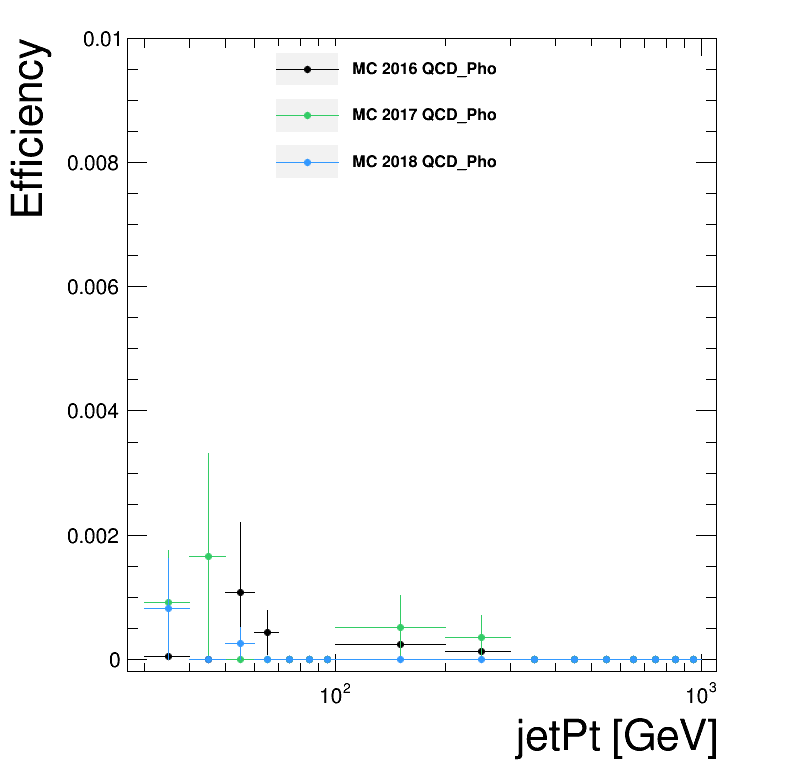

In [28]:

   

color_list = [1,845,861,806,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
  

    for case in cases:
        print(case)
        outf = 'tag_eff_jet_'+var[2]+'_rebin_linearX_'+case+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if case in k:
                if 'bb' not in k:
        #         if 'QCD' in k:
                    pEff[k] = var[1][k]
        #             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
        #             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
                    pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

                    pEff[k].SetLineColor(color_list[i])
                    pEff[k].SetMarkerColor(color_list[i])
                    pEff[k].SetMarkerSize(0.8)
                    pEff[k].SetMarkerStyle(20)

                    if i==0:
                        pEff[k].Draw("apez")
                    else:
                        pEff[k].Draw("pezsame")

                    rt.gPad.Update()        
                    #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
                    pEff[k].GetPaintedGraph().SetMarkerStyle(8)
                    pEff[k].GetPaintedGraph().SetMarkerSize(20)        
                    pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
                    pEff[k].GetPaintedGraph().SetMinimum(var[3])
                    pEff[k].GetPaintedGraph().SetMaximum(var[4])
                    pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
                    pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


                    i += 1



                    leg.AddEntry(pEff[k],k)

        leg.Draw()

        c.SetLogx()
    #     c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


In [29]:
variables = [
    
 
        ['jetPt [GeV]', pt_denall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
2018
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
2018
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPP

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_Data.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_MC.png has been created


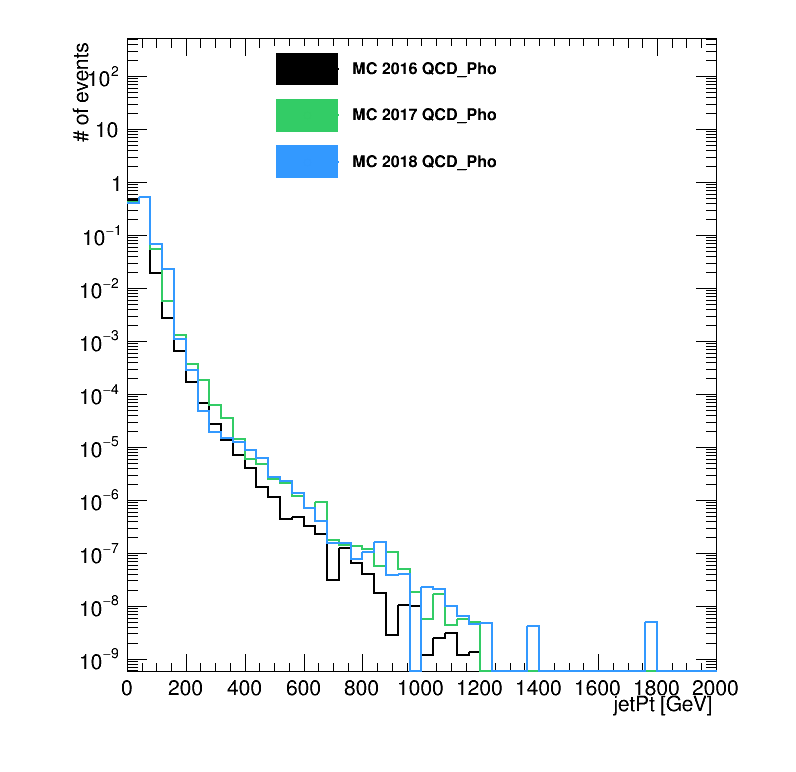

In [30]:

   

color_list = [1,845,861,806,876,597,625]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    for case in cases:
        print(yr)
        outf = 'pt_jet_'+case+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if case in k:


                if 'bb' not in k:
                    ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wall[k])


                    ptHist[k].SetLineColor(color_list[i])
                    ptHist[k].SetMarkerColor(color_list[i])
                    ptHist[k].SetMarkerSize(0.8)
                    ptHist[k].SetMarkerStyle(20)

        #             if i==0:
        #                 ptHist[k].Draw("ahist")
        #             else:
        #                 ptHist[k].Draw("histsame")

        #            ptHist[k].Sumw2()

                    ptHist[k].GetXaxis().SetTitleSize(0.03)
                    ptHist[k].GetYaxis().SetTitleSize(0.03)
                    ptHist[k].GetXaxis().SetLabelSize(0.03)
                    ptHist[k].GetYaxis().SetLabelSize(0.03)
                    ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
                    ptHist[k].DrawNormalized("Hist same")

                    peHist[k] =ptHist[k].Clone()
                    peHist[k].SetFillColor(color_list[i])
                    #            peHist[k].Draw("e2 same")

                    leg.AddEntry(peHist[k],k )


                    i += 1


        leg.Draw()

    #     c.SetLogx()
        c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


In [31]:
variables = [
    
 
        ['jetPt [GeV]', pt_numall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
2018
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b89426ef0>
2018
Data 2016B-F SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ffb3c8>
Data 2016G-H SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88f59ef0>
Data 2017 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b88ccf1d0>
Data 2018 SinglePhoton <TTree b'SusyLLPPassFailTree' at 0x7f2b8945b7f0>
MC 2016 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b88cc02e8>
MC 2017 QCD_Pho <TTree b'SusyLLPPassFailTree' at 0x7f2b8905fe10>
MC 2018 QCD_Pho <TTree b'SusyLLPP

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_pass_Data.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200729/Pho_pileupW/pt_jet_pass_MC.png has been created


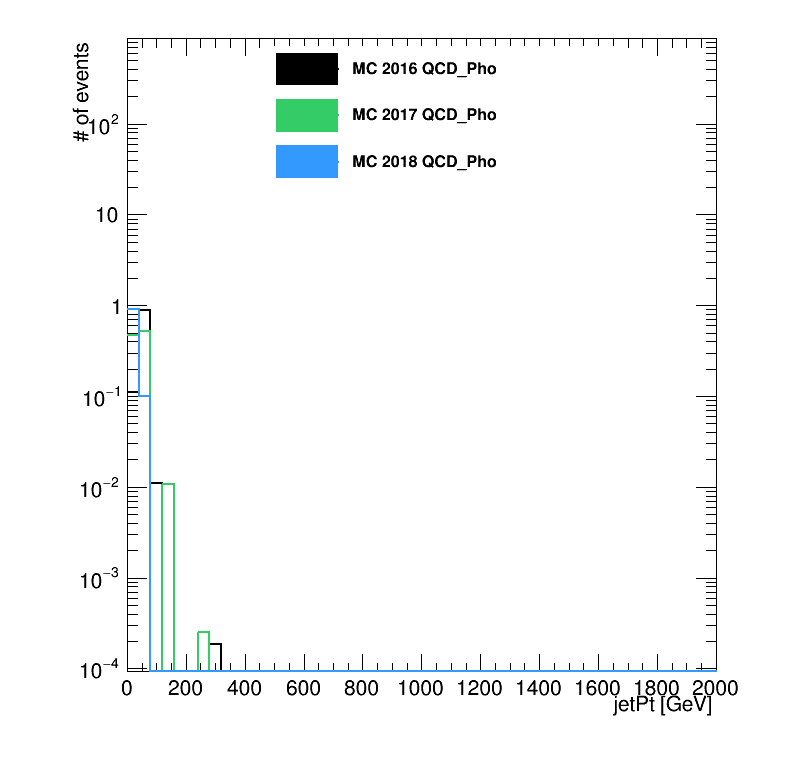

In [32]:

   

color_list = [1,845,861,806,876,597,625]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    for case in cases:
        print(yr)
        outf = 'pt_jet_pass_'+case+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        i = 0
        for k,v in tree.items(): 
            print(k,v)

            if case in k:


                if 'bb' not in k:
                    ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wnum[k])


                    ptHist[k].SetLineColor(color_list[i])
                    ptHist[k].SetMarkerColor(color_list[i])
                    ptHist[k].SetMarkerSize(0.8)
                    ptHist[k].SetMarkerStyle(20)

        #             if i==0:
        #                 ptHist[k].Draw("ahist")
        #             else:
        #                 ptHist[k].Draw("histsame")

        #            ptHist[k].Sumw2()

                    ptHist[k].GetXaxis().SetTitleSize(0.03)
                    ptHist[k].GetYaxis().SetTitleSize(0.03)
                    ptHist[k].GetXaxis().SetLabelSize(0.03)
                    ptHist[k].GetYaxis().SetLabelSize(0.03)
                    ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
                    ptHist[k].DrawNormalized("Hist same")

                    peHist[k] =ptHist[k].Clone()
                    peHist[k].SetFillColor(color_list[i])
                    #            peHist[k].Draw("e2 same")

                    leg.AddEntry(peHist[k],k )


                    i += 1


        leg.Draw()

    #     c.SetLogx()
        c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)
